# Sign Hand Gesture Recognition by Artificial Neural Network

<a href="https://colab.research.google.com/github/UOMDSS/workshops-2022-2023/blob/main/semester-1/Week-9-Sign-Gesture-Artificial-Neural-Network/ANN_Sign_Gesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.1 Download sign MNIST datasets

In [1]:
! mkdir -p dataset/
! wget -q -O dataset/sign_mnist_train.csv https://github.com/UOMDSS/workshops-2022-2023/raw/main/semester-1/Week-9-Sign-Gesture-Artificial-Neural-Network/dataset/sign_mnist_train.csv
! wget -q -O dataset/sign_mnist_test.csv https://github.com/UOMDSS/workshops-2022-2023/raw/main/semester-1/Week-9-Sign-Gesture-Artificial-Neural-Network/dataset/sign_mnist_test.csv

The syntax of the command is incorrect.


## 0.2 Peek and visualise dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# A-Z but no cases for 9=J and 25=Z
label_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}

def show_picture(values):
    image_array = np.asfarray(values[1:]).reshape((28, 28))
    plt.imshow(image_array, cmap='magma', interpolation='None')
    plt.xlabel(label_dict[values[0]], fontsize=20, color='#3B054F')
    plt.xticks([])
    plt.yticks([])

with open('dataset/sign_mnist_train.csv', 'r') as f:
    training_data_list = f.readlines()

Each line of the data file contains 1 label value + 784 (28x28) pixel values (0~255).

In [3]:
print(training_data_list[0])

3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,163,164,170,119,152,171,171,170,171,172,172,172,172,172,171,171,170,113,123,131,137,142,145,150,152,155,158,161,163,164,172,105,142,170,171,171,171,172,172,173,173,172,171,171,171,116,125,133,139,143,146,151,153,156,159,162,163,167,167,95,144,171,172,172,172,172,172,173,173,173,172,172,171,117,126,134,140,145,149,153,156,158,161,163,164,175,156,87,154,172,173,173,173,173,173,174,174,174,173,172,172,119,128,136,142,146,150,153,156,159,163,165,164,184,148,89,164,172,174,174,174,174,175,175,174,175,174,173,173,122,130,138,143,147,150,154,158,162,165,166,172,181,128,94,170,173,175,174,175,176,177,177,177,177,175,175,174,122,132,139,145,149,152,156,160,163,165,166,181,172,103,113,175,176,178,178,179,179,179,179,178,179,177,175,174,125,134,141,147,150,153,157,161,164,167,168,184,179,116,126,165,176,179,180,180,181,180,180,180,179,178,17

Visualisation.

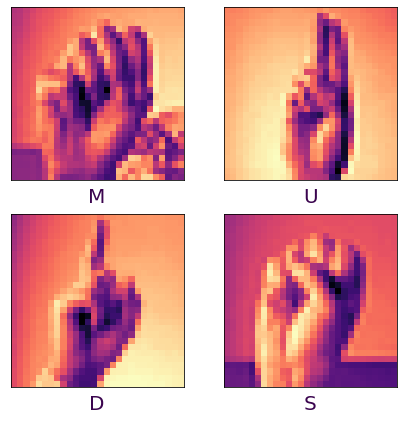

In [4]:
plt.figure(figsize=(7, 7))
for i, l in enumerate([31, 14, 0, 10]):
    plt.subplot(2, 2, i+1)
    data_array = [int(x) for x in training_data_list[l].split(',')]
    show_picture(data_array)
plt.show()

## 1.1 Import PyTorch libraries and setup device

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 1.2 Define hyperparameters

In [6]:
input_nodes = 784     #@param {type:"integer"}
hidden_nodes = 200    #@param {type:"integer"}
output_nodes = 24     #@param {type:"integer"}
batch_size = 16       #@param {type:"integer"}
learning_rate = 0.03  #@param {type:"number"}
epochs = 10           #@param {type:"integer"}

## 1.3 Define dataset class

In [7]:
class SignMNIST(Dataset):
    def __init__(self, filePath):
        # read dataset
        self.data_array = []
        for line in open(filePath, 'r'):
            sample = [int(pixel) for pixel in line.split(',')]
            # skip class 'J'
            if sample[0] > 9:
                sample[0] -= 1
            # filter out number of classes
            if sample[0] < output_nodes:
                self.data_array.append(sample)

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, idx):
        sample = self.data_array[idx]
        # normalise data
        data = torch.tensor(sample[1:], dtype=torch.float32) / 255.0
        label = torch.tensor(sample[0], dtype=torch.float32)
        return data, label

## 1.4 Define model

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # initialise weights
        self.wih = nn.Parameter(torch.normal(torch.zeros(hidden_nodes, input_nodes), hidden_nodes ** -0.5))
        self.who = nn.Parameter(torch.normal(torch.zeros(output_nodes, hidden_nodes), output_nodes ** -0.5))

        # activation function
        self.sigmoid = lambda x: 1 / (1 + torch.exp(-x))

    def forward(self, inputs):
        # input layer
        inputs = inputs.T

        # hidden layer
        hidden_outputs = self.sigmoid(self.wih @ inputs)

        # output layer
        final_outputs = self.sigmoid(self.who @ hidden_outputs)

        return final_outputs.T

## 1.5 Define loss function

In [9]:
def loss_fn(y_pred, y):
    y = F.one_hot(y.to(torch.int64), output_nodes).to(torch.float32)
    # sum of squares error
    return torch.sum(torch.square(y_pred - y))

## 1.6 Initialise instances

In [10]:
train_dataloader = DataLoader(SignMNIST('dataset/sign_mnist_train.csv'), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(SignMNIST('dataset/sign_mnist_test.csv'), batch_size=batch_size, shuffle=True)

model = NeuralNetwork().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## 1.7 Define training loop

In [11]:
def train_loop():
    size = len(train_dataloader.dataset)
    for batch_no, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_no + 1) % (3000 // batch_size) == 0:
            loss, current = loss.item(), batch_no * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## 1.8 Define testing loop

In [12]:
def test_loop():
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 1.9 Start loops

In [13]:
for t in range(epochs):
    print(f"Epoch {t+1} / {epochs}\n-------------------------------")
    train_loop()
    test_loop()

Epoch 1 / 10
-------------------------------
loss: 15.498077  [ 2976/27455]
loss: 15.983711  [ 5968/27455]
loss: 15.530413  [ 8960/27455]
loss: 15.551739  [11952/27455]
loss: 15.116749  [14944/27455]
loss: 15.243013  [17936/27455]
loss: 15.570773  [20928/27455]
loss: 15.311512  [23920/27455]
loss: 15.076534  [26912/27455]
Test Error: 
 Accuracy: 22.3%, Avg loss: 14.424494 

Epoch 2 / 10
-------------------------------
loss: 14.935139  [ 2976/27455]
loss: 13.670328  [ 5968/27455]
loss: 13.815334  [ 8960/27455]
loss: 12.993930  [11952/27455]
loss: 12.081172  [14944/27455]
loss: 13.012850  [17936/27455]
loss: 13.746199  [20928/27455]
loss: 9.554167  [23920/27455]
loss: 10.155169  [26912/27455]
Test Error: 
 Accuracy: 42.8%, Avg loss: 11.808395 

Epoch 3 / 10
-------------------------------
loss: 11.084530  [ 2976/27455]
loss: 11.644082  [ 5968/27455]
loss: 11.571758  [ 8960/27455]
loss: 8.826068  [11952/27455]
loss: 8.941390  [14944/27455]
loss: 9.457027  [17936/27455]
loss: 9.260800  [20

## 2.0 Model prediction

In [14]:
idx = 10
test_dataset = SignMNIST('dataset/sign_mnist_test.csv')
X, y = test_dataset[idx]
X, y = X.unsqueeze(0).to(device), y.to(device)
pred = model(X)
pred = pred.argmax(1)[0]
print(f"Predicted value: {pred.item()}, Real label: {int(y.item())}")

Predicted value: 8, Real label: 8
